# MAS Evaluation with Vertex AI

Use this notebook to benchmark Automated Multi-Agent System (MAS) investigation reports against the curated ground truth using a Vertex AI LLM-as-Judge workflow.

## Prerequisites

1. Activate the project virtual environment and install dependencies (`pip install -r requirements.txt`).
2. Set Google Cloud credentials so that Vertex AI can be accessed (e.g., `export GOOGLE_APPLICATION_CREDENTIALS=secrets/gcp.json`).
3. Set Vertex AI environment variables: `export AMAS_VERTEX_PROJECT=<gcp-project>` and optionally `export AMAS_VERTEX_LOCATION=europe-west4`.
4. Generate MAS investigation reports into `../data/output/<scenario>.json` (a JSON file per alert scenario).

In [3]:
import json
import os
from pathlib import Path
from statistics import mean
from string import Template
from typing import Any, Dict, List, Optional

from dotenv import load_dotenv

try:
    import vertexai
    from vertexai.generative_models import GenerativeModel
except ImportError as exc:
    raise ImportError("Install the Vertex AI SDK: pip install google-cloud-aiplatform") from exc

ROOT_DIR = Path('..').resolve()
ENV_PATH = ROOT_DIR / '.env'
if ENV_PATH.is_file():
    load_dotenv(ENV_PATH)
else:
    load_dotenv()  # fall back to default lookup

credentials_setting = os.getenv('GOOGLE_APPLICATION_CREDENTIALS')
if credentials_setting:
    credentials_path = Path(credentials_setting)
    if not credentials_path.is_absolute():
        resolved_credentials = (ROOT_DIR / credentials_path).resolve()
        if resolved_credentials.is_file():
            os.environ['GOOGLE_APPLICATION_CREDENTIALS'] = str(resolved_credentials)
            credentials_setting = str(resolved_credentials)
        else:
            print(
                f"WARNING: Expected Vertex credentials at {resolved_credentials} but the file was not found."
            )

GROUND_TRUTH_PATH = ROOT_DIR / 'data' / 'ground_truth.json'
AGENT_OUTPUT_DIR = ROOT_DIR / 'data' / 'output'
DEFAULT_MODEL_NAME = os.getenv('AMAS_JUDGE_MODEL', 'gemini-2.5-flash')

if not GROUND_TRUTH_PATH.is_file():
    raise FileNotFoundError(f"Ground truth data not found at {GROUND_TRUTH_PATH}")

with GROUND_TRUTH_PATH.open('r', encoding='utf-8') as handle:
    _ground_truth_rows: List[Dict[str, Any]] = json.load(handle)

GROUND_TRUTH = {row['scenario']: row for row in _ground_truth_rows}
print(f"Loaded {len(GROUND_TRUTH)} scenarios from {GROUND_TRUTH_PATH}")

COMBINED_REPORTS_PATH = ROOT_DIR / 'data' / 'output' / 'combined_reports.json'
COMBINED_SCENARIOS: Dict[str, Dict[str, Any]] = {}
COMBINED_REPORT_CACHE: Dict[str, Dict[str, Any]] = {}

if COMBINED_REPORTS_PATH.is_file():
    with COMBINED_REPORTS_PATH.open('r', encoding='utf-8') as handle:
        _combined_payload: Dict[str, Any] = json.load(handle)
    for entry in _combined_payload.get('scenarios', []):
        name = entry.get('scenario')
        if name:
            COMBINED_SCENARIOS[name] = entry
    completed_count = sum(1 for item in COMBINED_SCENARIOS.values() if item.get('status') == 'completed')
    print(
        f"Loaded {len(COMBINED_SCENARIOS)} combined MAS reports from {COMBINED_REPORTS_PATH} (completed={completed_count})"
    )
else:
    print(
        f"Combined report not found at {COMBINED_REPORTS_PATH}; expecting individual JSON files in {AGENT_OUTPUT_DIR}"
    )



Loaded 30 scenarios from C:\Development\amas\data\ground_truth.json
Loaded 30 combined MAS reports from C:\Development\amas\data\output\combined_reports.json (completed=27)


### Environment Check

Confirm the Vertex AI configuration before running any evaluations. Update `.env` or export variables if any entries are marked as MISSING.

In [4]:
import os

required_vars = ['AMAS_VERTEX_PROJECT', 'AMAS_VERTEX_LOCATION', 'GOOGLE_APPLICATION_CREDENTIALS']
for var in required_vars:
    value = os.getenv(var)
    status = 'SET' if value else 'MISSING'
    detail = f" -> {value}" if value else ""
    print(f"{var}: {status}{detail}")



AMAS_VERTEX_PROJECT: SET -> prudai
AMAS_VERTEX_LOCATION: SET -> europe-west4
GOOGLE_APPLICATION_CREDENTIALS: SET -> C:\Development\amas\secrets\gcp.json


### Helper Functions

Utilities for loading agent outputs, building the judge prompt, calling Vertex AI, and flattening the response payload.

In [5]:
import re
SYSTEM_PROMPT_PATH = ROOT_DIR / 'data' / 'documentation' / 'SYSTEM_PROMPT.md'


def load_judge_prompt_template() -> Template:
    text = SYSTEM_PROMPT_PATH.read_text(encoding='utf-8')
    marker = '### 4. Evaluation Judge Prompt Template'
    if marker not in text:
        raise ValueError(f"Unable to locate '{marker}' in {SYSTEM_PROMPT_PATH}")
    section = text.split(marker, 1)[1]
    parts = section.split('```')
    if len(parts) < 2:
        raise ValueError('Judge prompt fenced block not found in SYSTEM_PROMPT.md')
    # Join all fenced segments to preserve nested code blocks
    raw_template = '```'.join(parts[1:]).strip()
    return Template(raw_template)

JUDGE_PROMPT_TEMPLATE = load_judge_prompt_template()


def _clean_json_block(raw_block: str) -> str:
    text = raw_block.strip()
    if text.startswith('```'):
        parts = text.split('```')
        if len(parts) >= 2:
            text = parts[1]
        text = text.strip()
    if text.lower().startswith('json'):
        text = text[4:].lstrip()
    return text


CODE_FENCE_PATTERN = re.compile(r'```(?:json)?\s*(.*?)```', re.IGNORECASE | re.DOTALL)


def _json_candidates(raw_text: str) -> list[str]:
    text = (raw_text or '').strip()
    candidates: list[str] = []
    seen: set[str] = set()

    def push(value: str | None) -> None:
        if not value:
            return
        stripped = value.strip()
        if stripped and stripped not in seen:
            candidates.append(stripped)
            seen.add(stripped)

    push(text)
    push(_clean_json_block(text))
    for match in CODE_FENCE_PATTERN.finditer(text):
        push(match.group(1))
    return candidates


def parse_agent_output(raw_block: str) -> Dict[str, Any]:
    text = raw_block if isinstance(raw_block, str) else json.dumps(raw_block)
    candidates = _json_candidates(text)
    first_error: json.JSONDecodeError | None = None
    for candidate in candidates:
        try:
            return json.loads(candidate)
        except json.JSONDecodeError as err:
            if first_error is None:
                first_error = err
    if not candidates:
        raise ValueError('MAS agent output payload is empty')
    if first_error is None:
        raise ValueError('Unable to parse MAS agent output payload as JSON')
    raise ValueError('Unable to parse MAS agent output payload as JSON') from first_error


def scenario_to_filename(scenario: str) -> str:
    slug = scenario.lower().strip()
    slug = re.sub(r'[^a-z0-9]+', '_', slug)
    slug = re.sub(r'_+', '_', slug).strip('_')
    return slug


def candidate_paths_for_scenario(scenario: str) -> list[Path]:
    variants = {
        scenario,
        scenario.replace(' ', '_'),
        scenario.replace(' ', '-'),
        scenario.lower(),
        scenario.lower().replace(' ', '_'),
        scenario.lower().replace(' ', '-'),
        scenario_to_filename(scenario),
        scenario_to_filename(scenario).replace('_', '-'),
    }
    candidates = []
    for variant in variants:
        variant = variant.strip()
        if not variant:
            continue
        if not variant.lower().endswith('.json'):
            candidates.append(AGENT_OUTPUT_DIR / f"{variant}.json")
            candidates.append(AGENT_OUTPUT_DIR / f"{variant}.JSON")
        else:
            candidates.append(AGENT_OUTPUT_DIR / variant)
    return candidates


def resolve_agent_report_path(scenario: str) -> Path | None:
    # Direct variants first
    for path in candidate_paths_for_scenario(scenario):
        if path.is_file():
            return path
    # Fallback: fuzzy search within data/output
    if AGENT_OUTPUT_DIR.is_dir():
        slug = scenario_to_filename(scenario)
        for path in AGENT_OUTPUT_DIR.glob('*.json'):
            if slug in scenario_to_filename(path.stem):
                return path
    return None


def list_missing_reports() -> list[str]:
    missing: list[str] = []
    for scenario in GROUND_TRUTH:
        combined_entry = COMBINED_SCENARIOS.get(scenario)
        if combined_entry:
            report_meta = combined_entry.get('report')
            raw_payload = report_meta.get('raw') if report_meta else None
            if (
                not report_meta
                or not isinstance(raw_payload, str)
                or not raw_payload.strip()
                or not _clean_json_block(raw_payload)
            ):
                status = combined_entry.get('status', 'unknown')
                missing.append(f"{scenario} (status={status})")
            continue
        if resolve_agent_report_path(scenario) is None:
            missing.append(scenario)
    return missing

def load_agent_report(scenario: str) -> dict[str, Any]:
    if scenario in COMBINED_REPORT_CACHE:
        return COMBINED_REPORT_CACHE[scenario]

    combined_entry = COMBINED_SCENARIOS.get(scenario)
    if combined_entry:
        status = combined_entry.get('status')
        report_meta = combined_entry.get('report')
        if status != 'completed':
            raise FileNotFoundError(
                f"Combined report for '{scenario}' has status '{status}'. Run the MAS pipeline before scoring."
            )
        if not report_meta:
            raise FileNotFoundError(f"Combined report for '{scenario}' is missing a 'raw' payload")
        raw_payload = report_meta.get('raw')
        if not isinstance(raw_payload, str) or not raw_payload.strip():
            raise FileNotFoundError(f"Combined report for '{scenario}' is missing a 'raw' payload")
        if not _clean_json_block(raw_payload):
            raise FileNotFoundError(f"Combined report for '{scenario}' has an empty 'raw' payload")
        parsed_payload = parse_agent_output(raw_payload)
        COMBINED_REPORT_CACHE[scenario] = parsed_payload
        return parsed_payload

    path = resolve_agent_report_path(scenario)
    if path is None:
        raise FileNotFoundError(
            f"Could not locate an agent report for '{scenario}'. "
            "Place the MAS output JSON under data/output with a recognisable filename."
        )
    with path.open('r', encoding='utf-8') as handle:
        payload = json.load(handle)
    if isinstance(payload, str):
        if not payload.strip():
            raise FileNotFoundError(f"Agent report at '{path}' contains an empty JSON payload")
        if not _clean_json_block(payload):
            raise FileNotFoundError(f"Agent report at '{path}' contains an empty fenced JSON payload")
        payload = parse_agent_output(payload)
    return payload

def initialise_vertex(model_name: str = DEFAULT_MODEL_NAME) -> GenerativeModel:
    project = os.environ.get('AMAS_VERTEX_PROJECT')
    location = os.environ.get('AMAS_VERTEX_LOCATION', 'europe-west4')
    if not project:
        raise EnvironmentError('Set AMAS_VERTEX_PROJECT before calling the judge model.')
    vertexai.init(project=project, location=location)
    return GenerativeModel(model_name)


def call_judge(
    scenario: str,
    agent_report: dict[str, Any],
    model: GenerativeModel,
    temperature: float = 0.1,
) -> dict[str, Any]:
    ground_truth = GROUND_TRUTH[scenario]
    prompt = JUDGE_PROMPT_TEMPLATE.substitute(
        ground_truth=json.dumps(ground_truth, indent=2),
        agent_report=json.dumps(agent_report, indent=2),
    )
    response = model.generate_content(
        prompt,
        generation_config={'temperature': temperature},
    )
    text_response = getattr(response, 'text', '').strip()
    if not text_response and getattr(response, 'candidates', None):
        text_response = response.candidates[0].content.parts[0].text
    text_response = (text_response or '').strip()
    candidates = _json_candidates(text_response)
    first_error: json.JSONDecodeError | None = None
    for candidate in candidates:
        try:
            return json.loads(candidate)
        except json.JSONDecodeError as err:
            if first_error is None:
                first_error = err
    if not candidates:
        raise ValueError('Judge response was empty')
    if first_error is None:
        raise ValueError(f'Judge response was not valid JSON: {text_response}')
    raise ValueError(f'Judge response was not valid JSON: {text_response}') from first_error


def evaluate_scenario(
    scenario: str,
    model: GenerativeModel | None = None,
) -> dict[str, Any]:
    if scenario not in GROUND_TRUTH:
        raise KeyError(f'Unknown scenario: {scenario}')
    report = load_agent_report(scenario)
    model = model or initialise_vertex()
    return call_judge(scenario, report, model)


def flatten_evaluation(scenario: str, evaluation: dict[str, Any]) -> dict[str, Any]:
    summary = evaluation['evaluation_summary']
    return {
        'scenario': scenario,
        'verdict_score': summary['verdict_accuracy']['score'],
        'severity_score': summary['severity_assessment']['score'],
        'evidence_score': summary['evidence_discovery']['score'],
        'actionability_score': summary['actionability_of_response']['score'],
        'overall_score': summary['overall_score'],
        'verdict_notes': summary['verdict_accuracy']['reasoning'],
        'severity_notes': summary['severity_assessment']['reasoning'],
        'evidence_notes': summary['evidence_discovery']['reasoning'],
        'actionability_notes': summary['actionability_of_response']['reasoning'],
        'reasoning_quality': summary.get('reasoning_quality_assessment', ''),
    }



### Verify Available Agent Reports

Run this cell to confirm that a MAS investigation output exists for every scenario. Missing files must be generated before evaluation.

In [6]:
missing = list_missing_reports()
if missing:
    print('Missing agent reports:')
    for item in missing:
        print(f" - {item}")
else:
    print('All scenarios have agent reports ready for evaluation.')


Missing agent reports:
 - Benign - Cloud Storage Sync (status=failed)
 - Suspicious - Internal Port Scan (Lateral Movement) (status=completed)
 - Suspicious - New Admin Account Creation (status=failed)
 - Malicious - New Service Creation for Persistence (status=failed)
 - Suspicious - High Volume of Outbound SMTP Traffic (status=completed)


### Evaluate a Single Scenario

Run the judge against one scenario to review the structured feedback.

In [7]:
# Replace with the scenario you want to score
scenario_name = "Malicious - Malware Command & Control (C2) Communication"
model = initialise_vertex()
evaluation = evaluate_scenario(scenario_name, model=model)
print(json.dumps(evaluation, indent=2))


C:\Development\amas\.venv\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


{
  "evaluation_summary": {
    "verdict_accuracy": {
      "score": 10,
      "reasoning": "The agent's `final_verdict` of 'True Positive' perfectly matches the `expected_verdict` in the Ground Truth."
    },
    "severity_assessment": {
      "score": 10,
      "reasoning": "The agent's `calculated_severity` of 'Critical' falls precisely within the `expected_severity_range` of ['Critical']."
    },
    "evidence_discovery": {
      "score": 6,
      "reasoning": "The agent successfully located the key threat intelligence indicator (IOC-IP-001) and the CMDB asset details (Workstation-Finance03). It also identified the relevant VLAN policy and a violation, though it missed the specific VLAN ID (120) and the full policy text. However, it completely missed providing the specific EDR event logs (FileWrite, ProcessCreate), the DNS query log, and the Web proxy CONNECT log, which were explicitly listed as `key_evidence_to_find` and should have been in `correlated_log_evidence`."
    },
    "

In [8]:
# Optional: view the flattened metrics for quick comparison
flattened = flatten_evaluation(scenario_name, evaluation)
print(json.dumps(flattened, indent=2))


{
  "scenario": "Malicious - Malware Command & Control (C2) Communication",
  "verdict_score": 10,
  "severity_score": 10,
  "evidence_score": 6,
  "actionability_score": 10,
  "overall_score": 9,
  "verdict_notes": "The agent's `final_verdict` of 'True Positive' perfectly matches the `expected_verdict` in the Ground Truth.",
  "severity_notes": "The agent's `calculated_severity` of 'Critical' falls precisely within the `expected_severity_range` of ['Critical'].",
  "evidence_notes": "The agent successfully located the key threat intelligence indicator (IOC-IP-001) and the CMDB asset details (Workstation-Finance03). It also identified the relevant VLAN policy and a violation, though it missed the specific VLAN ID (120) and the full policy text. However, it completely missed providing the specific EDR event logs (FileWrite, ProcessCreate), the DNS query log, and the Web proxy CONNECT log, which were explicitly listed as `key_evidence_to_find` and should have been in `correlated_log_evid

### Batch Evaluation

Evaluate every scenario, compute the aggregate score, and persist the detailed breakdown to `../data/evaluations/vertex_judge_results.json`.

In [9]:
all_rows = []
model = initialise_vertex()
for scenario in sorted(GROUND_TRUTH.keys()):
    try:
        evaluation = evaluate_scenario(scenario, model=model)
        row = flatten_evaluation(scenario, evaluation)
        all_rows.append(row)
        print(f"Evaluated {scenario}: overall={row['overall_score']:.2f}")
    except FileNotFoundError as exc:
        print(f"Skipping {scenario}: {exc}")

if not all_rows:
    raise RuntimeError('No scenarios were evaluated. Ensure agent reports exist in data/output/.')

overall_average = mean(row['overall_score'] for row in all_rows)
print(f"Average overall score across {len(all_rows)} scenarios: {overall_average:.2f}")

output_path = Path('../data/evaluations/vertex_judge_results.json')
output_path.parent.mkdir(parents=True, exist_ok=True)
with output_path.open('w', encoding='utf-8') as handle:
    json.dump(all_rows, handle, indent=2)
print(f"Wrote detailed results to {output_path}")


C:\Development\amas\.venv\Lib\site-packages\vertexai\generative_models\_generative_models.py:433: UserWarning: This feature is deprecated as of June 24, 2025 and will be removed on June 24, 2026. For details, see https://cloud.google.com/vertex-ai/generative-ai/docs/deprecations/genai-vertexai-sdk.
  warning_logs.show_deprecation_warning()


Evaluated Benign - API Call to SaaS Platform: overall=7.50
Evaluated Benign - Admin RDP to Server: overall=8.50
Skipping Benign - Cloud Storage Sync: Combined report for 'Benign - Cloud Storage Sync' has status 'failed'. Run the MAS pipeline before scoring.
Evaluated Benign - Developer Using Nmap on Staging: overall=10.00
Evaluated Benign - Remote Employee VPN Access: overall=8.25
Evaluated Benign - Vulnerability Scan: overall=9.75
Evaluated Benign - Windows Update: overall=4.00
Evaluated Malicious - Brute Force Login Attempt (SSH): overall=10.00
Evaluated Malicious - Credential Dumping from LSASS: overall=9.50
Evaluated Malicious - Data Exfiltration via DNS Tunneling: overall=8.88
Evaluated Malicious - Malware Command & Control (C2) Communication: overall=8.50
Skipping Malicious - New Service Creation for Persistence: Combined report for 'Malicious - New Service Creation for Persistence' has status 'failed'. Run the MAS pipeline before scoring.
Evaluated Malicious - Outbound FTP Data 

### Visualise Judge Scores

Use the aggregated LLM-as-a-judge results to generate quick charts for scenario performance.

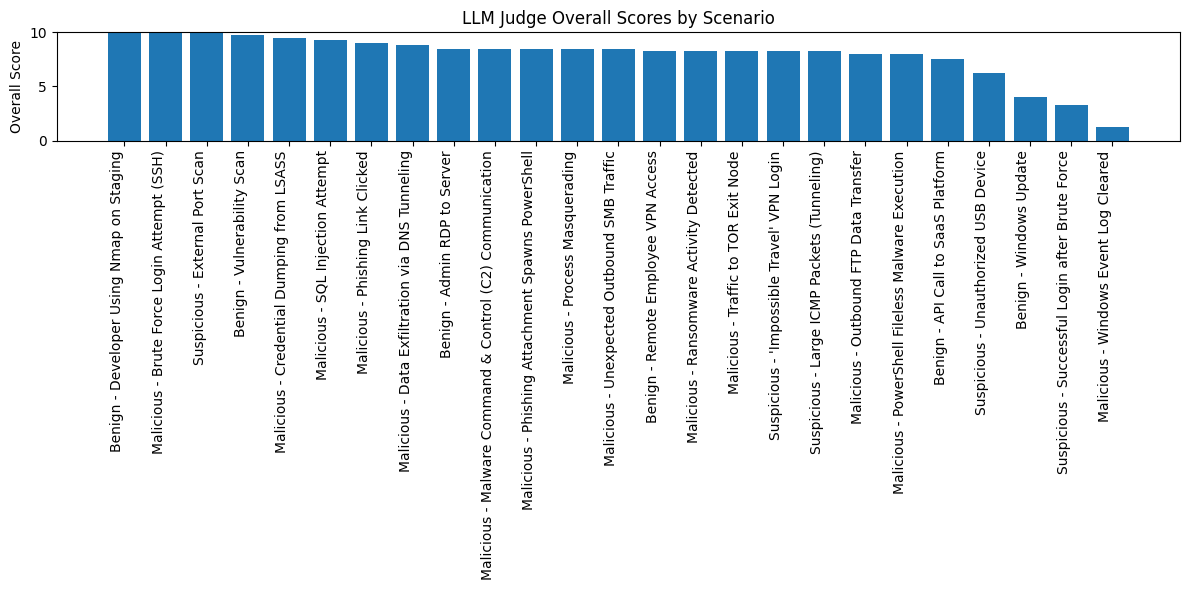

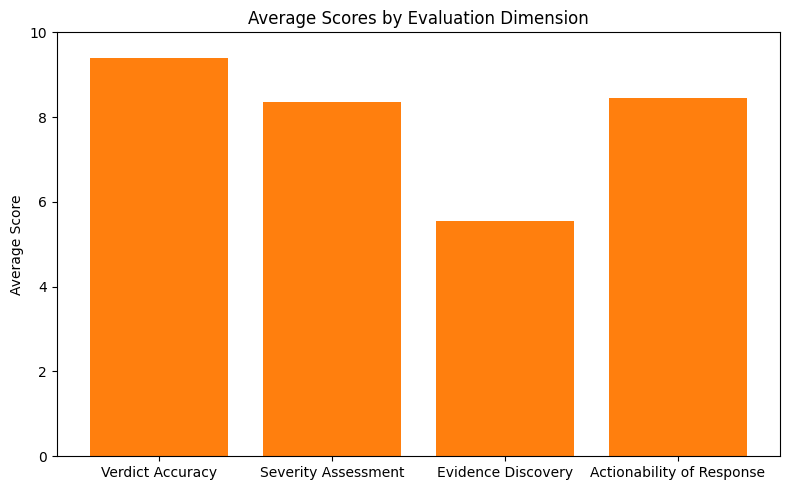

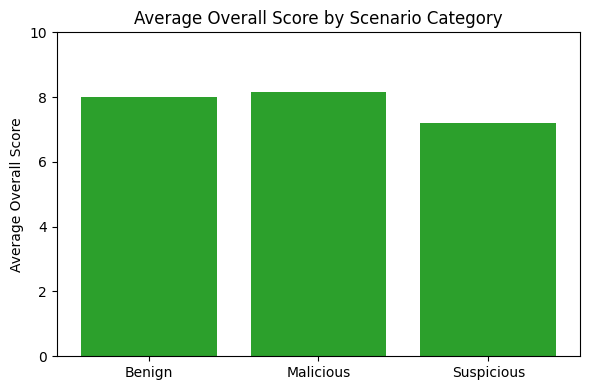

In [10]:
import json
from collections import defaultdict
from pathlib import Path

import matplotlib.pyplot as plt

try:
    rows = all_rows  # type: ignore[name-defined]
except NameError:
    results_path = Path('../data/evaluations/vertex_judge_results.json')
    if not results_path.is_file():
        raise FileNotFoundError('Run the batch evaluation cell first to generate results.')
    with results_path.open('r', encoding='utf-8') as handle:
        rows = json.load(handle)

if not rows:
    raise ValueError('No evaluation rows available for visualisation.')

sorted_rows = sorted(rows, key=lambda row: row['overall_score'], reverse=True)
scenarios = [row['scenario'] for row in sorted_rows]
overall_scores = [row['overall_score'] for row in sorted_rows]

plt.figure(figsize=(12, 6))
plt.bar(range(len(overall_scores)), overall_scores, color='#1f77b4')
plt.xticks(range(len(scenarios)), scenarios, rotation=90, ha='right')
plt.ylabel('Overall Score')
plt.ylim(0, 10)
plt.title('LLM Judge Overall Scores by Scenario')
plt.tight_layout()
plt.show()

category_labels = ['verdict_score', 'severity_score', 'evidence_score', 'actionability_score']
category_titles = ['Verdict Accuracy', 'Severity Assessment', 'Evidence Discovery', 'Actionability of Response']
category_averages = [mean(row[label] for row in rows) for label in category_labels]

plt.figure(figsize=(8, 5))
plt.bar(category_titles, category_averages, color='#ff7f0e')
plt.ylim(0, 10)
plt.ylabel('Average Score')
plt.title('Average Scores by Evaluation Dimension')
plt.tight_layout()
plt.show()

grouped_scores = defaultdict(list)
for row in rows:
    scenario_type = row['scenario'].split(' - ', 1)[0]
    grouped_scores[scenario_type].append(row['overall_score'])

group_names = sorted(grouped_scores)
group_averages = [mean(grouped_scores[name]) for name in group_names]

plt.figure(figsize=(6, 4))
plt.bar(group_names, group_averages, color='#2ca02c')
plt.ylim(0, 10)
plt.ylabel('Average Overall Score')
plt.title('Average Overall Score by Scenario Category')
plt.tight_layout()
plt.show()



### Inspect Saved Evaluation Results

Load the persisted JSON summary, highlight high/low performers, and optionally display a dataframe if pandas is installed.

In [11]:
results_path = Path('../data/evaluations/vertex_judge_results.json')
if not results_path.is_file():
    raise FileNotFoundError('Run the batch evaluation cell first to generate results.')

with results_path.open('r', encoding='utf-8') as handle:
    results = json.load(handle)

print(f"Loaded {len(results)} evaluation rows from {results_path}")
best = max(results, key=lambda row: row['overall_score'])
worst = min(results, key=lambda row: row['overall_score'])
print('Best overall scenario:', best['scenario'], 'score=', best['overall_score'])
print('Worst overall scenario:', worst['scenario'], 'score=', worst['overall_score'])

try:
    import pandas as pd
    df = pd.DataFrame(results)
    display(df.sort_values('overall_score', ascending=False))
except Exception as exc:
    print('Pandas not available or display failed:', exc)
    for row in sorted(results, key=lambda item: item['overall_score'], reverse=True):
        print(f"{row['scenario']}: overall={row['overall_score']:.2f}, verdict={row['verdict_score']}, evidence={row['evidence_score']}")


Loaded 25 evaluation rows from ..\data\evaluations\vertex_judge_results.json
Best overall scenario: Benign - Developer Using Nmap on Staging score= 10.0
Worst overall scenario: Malicious - Windows Event Log Cleared score= 1.25


,scenario,verdict_score,severity_score,evidence_score,actionability_score,overall_score,verdict_notes,severity_notes,evidence_notes,actionability_notes,reasoning_quality
21,Suspicious - External Port Scan,10,10,10.0,10,10.000,The agent's `final_verdict` of 'True Positive'...,The agent's `calculated_severity` of 'High' fa...,The agent successfully located all five key pi...,The agent's `course_of_action` is highly actio...,The agent's `triage_summary_text` demonstrates...
6,Malicious - Brute Force Login Attempt (SSH),10,10,10.0,10,10.000,The agent's `final_verdict` of 'True Positive'...,The agent's `calculated_severity` of 'High' fa...,The agent successfully located and presented a...,The agent's `course_of_action` is highly actio...,The agent's `triage_summary_text` demonstrates...
2,Benign - Developer Using Nmap on Staging,10,10,10.0,10,10.000,The agent's `final_verdict` of 'Benign True Po...,The agent's `calculated_severity` of 'Informat...,The agent successfully located both key pieces...,The agent's `course_of_action` aligns very clo...,The agent's reasoning quality is excellent. Th...
4,Benign - Vulnerability Scan,10,10,10.0,9,9.750,The agent's `final_verdict` of 'Benign True Po...,The agent's `calculated_severity` of 'Informat...,The agent successfully located both key pieces...,The agent's `next_steps_for_analyst` are highl...,The agent's `triage_summary_text` demonstrates...
7,Malicious - Credential Dumping from LSASS,10,10,8.0,10,9.500,The agent's final_verdict 'True Positive' perf...,The agent's calculated_severity 'Critical' fel...,The agent successfully identified the CMDB ass...,The agent provided a comprehensive and highly ...,The agent's triage summary demonstrates excell...
16,Malicious - SQL Injection Attempt,10,10,7.0,10,9.250,The agent's final verdict 'True Positive' perf...,The agent's calculated severity 'High' perfect...,The agent successfully identified the critical...,The agent's recommended course of action was c...,The agent's triage summary demonstrates excell...
12,Malicious - Phishing Link Clicked,10,10,6.0,10,9.000,The agent's `final_verdict` of 'True Positive'...,The agent's `calculated_severity` of 'High' fa...,The agent successfully identified the threat i...,The agent's `course_of_action` is highly actio...,The agent's `triage_summary_text` provides a c...
8,Malicious - Data Exfiltration via DNS Tunneling,10,8,7.5,10,8.875,"The agent's `final_verdict` of ""True Positive""...",The agent assessed the `calculated_severity` a...,The agent successfully identified the most cri...,The agent's `course_of_action` is highly actio...,The `triage_summary_text` demonstrates excelle...
9,Malicious - Malware Command & Control (C2) Com...,10,10,4.0,10,8.500,The agent's final verdict 'True Positive' perf...,The agent's calculated severity 'Critical' per...,The agent successfully identified the critical...,The agent's recommended course of action was e...,"The agent's reasoning quality, as demonstrated..."
11,Malicious - Phishing Attachment Spawns PowerShell,10,10,5.0,9,8.500,The agent's final verdict of 'True Positive' p...,The agent correctly assessed the severity as '...,The agent successfully identified the CMDB ass...,The agent provided a highly actionable and com...,"The agent's triage summary text is concise, ac..."
